# Prepare Import and stuffs

In [0]:
!pip install -U -q PyDrive
from pydrive.auth import GoogleAuth

from pydrive.drive import GoogleDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials


In [2]:
from keras.optimizers import Adam, RMSprop

from shutil import copyfile
import os
from keras.preprocessing.image import load_img ,img_to_array
import matplotlib.pyplot as plt

import keras
from keras import layers
import os
import tensorflow as tf
from keras.layers import BatchNormalization
import numpy as np
from skimage.io import imread
from skimage.transform import resize
from keras.utils.vis_utils import plot_model
import numpy as np
from skimage.io import imread
from skimage.transform import resize
import numpy as np
from tqdm import tqdm_notebook
import os 
from keras.preprocessing import image
from tqdm import tqdm_notebook



Using TensorFlow backend.


In [0]:
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [0]:
download = drive.CreateFile({'id': '1jdJXkQIWVGOeb0XJIXE3YuZQeiEPd8rM'})
download.GetContentFile('data.zip')

In [0]:
!unzip data.zip > /dev/null # Dont show any output

# Create Model

In [0]:
latent_dim = 100
height = 64
width = 64
channels = 3
import keras
from keras import layers
import os
import tensorflow as tf
from keras.layers import BatchNormalization

In [7]:
generator_input = keras.Input(shape=(latent_dim,))

x = layers.Dense(128 * 32 * 32)(generator_input)
x = layers.LeakyReLU()(x)
x = layers.Reshape((32, 32, 128))(x)

x = layers.Conv2D(256, 5, padding='same')(x)
x = layers.LeakyReLU()(x)

x = layers.Conv2DTranspose(256, 4, strides=2, padding='same')(x)
x = layers.LeakyReLU()(x)

x = layers.Conv2D(256, 5, padding='same')(x)
x = layers.LeakyReLU()(x)
x = layers.Conv2D(256, 5, padding='same')(x)
x = layers.LeakyReLU()(x)

x = layers.Conv2D(channels, 7, activation='tanh', padding='same')(x)
generator = keras.models.Model(generator_input, x)
generator.summary()




Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 100)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 131072)            13238272  
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 131072)            0         
_________________________________________________________________
reshape_1 (Reshape)          (None, 32, 32, 128)       0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 32, 32, 256)       819456    
_________________________________________________________________
leaky_re_lu_2 (LeakyReLU)    (None, 32, 32, 256)       0         
_________________________________________________________________
conv2d_transpose_1 (Conv2DTr (None, 64, 64, 256)       1

In [8]:


discriminator_input = layers.Input(shape=(height, width, channels))
x = layers.Conv2D(128, 3)(discriminator_input)
x = layers.LeakyReLU()(x)
x = layers.Conv2D(128, 4, strides=2)(x)
x = layers.LeakyReLU()(x)
x = layers.Conv2D(128, 4, strides=2)(x)
x = layers.LeakyReLU()(x)
x = layers.Conv2D(128, 4, strides=2)(x)
x = layers.LeakyReLU()(x)
x = layers.Flatten()(x)

x = layers.Dropout(0.4)(x)

x = layers.Dense(1, activation='sigmoid')(x)

discriminator = keras.models.Model(discriminator_input, x)
discriminator.summary()



Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 64, 64, 3)         0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 62, 62, 128)       3584      
_________________________________________________________________
leaky_re_lu_6 (LeakyReLU)    (None, 62, 62, 128)       0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 30, 30, 128)       262272    
_________________________________________________________________
leaky_re_lu_7 (LeakyReLU)    (None, 30, 30, 128)       0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 14, 14, 128)       262272    
_________

In [9]:
discriminator_optimizer = keras.optimizers.RMSprop(lr=0.0008, clipvalue=1.0, decay=1e-8)
discriminator.compile(optimizer=discriminator_optimizer, loss='binary_crossentropy')

discriminator.trainable = False

gan_input = keras.Input(shape=(latent_dim,))
gan_output = discriminator(generator(gan_input))
gan = keras.models.Model(gan_input, gan_output)

gan_optimizer = keras.optimizers.RMSprop(lr=0.0004, clipvalue=1.0, decay=1e-8)
gan.compile(optimizer=gan_optimizer, loss='binary_crossentropy')



Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


In [10]:
gan.summary()

Model: "model_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         (None, 100)               0         
_________________________________________________________________
model_1 (Model)              (None, 64, 64, 3)         18421507  
_________________________________________________________________
model_2 (Model)              (None, 1)                 795009    
Total params: 19,216,516
Trainable params: 18,421,507
Non-trainable params: 795,009
_________________________________________________________________


# Train Model

In [0]:
from skimage.transform import rescale
list_file = os.listdir('data')

# random.shuffle(list_file)
data_train_gan = np.array([resize(imread(os.path.join('data',file_name)), (64, 64)) for file_name in list_file])


In [0]:
x_train = data_train_gan
iterations = 100
batch_size = 36
save_dir = '.'


start = 0
import matplotlib.pyplot as plt

/usr/local/lib/python3.6/dist-packages/keras/engine/training.py:493: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


discriminator loss: 0.5563519
advesarial loss: 0.7991003


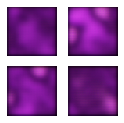

discriminator loss: 0.5563519
advesarial loss: 0.7991003


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


discriminator loss: 0.52307606
advesarial loss: 7.41863


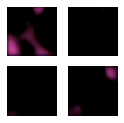

discriminator loss: 0.66268384
advesarial loss: 0.65263736


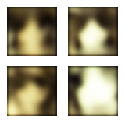

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


discriminator loss: 0.63436157
advesarial loss: 0.8394754


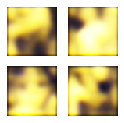

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


discriminator loss: 0.6048505
advesarial loss: 3.8996413


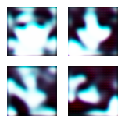

discriminator loss: 0.58540666
advesarial loss: 0.69581866


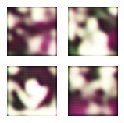

discriminator loss: 0.55511224
advesarial loss: 1.6980166


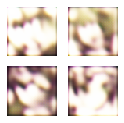

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


discriminator loss: 0.48900735
advesarial loss: 1.3254607


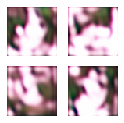

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


discriminator loss: 0.47528479
advesarial loss: 1.9697524


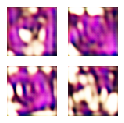

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


discriminator loss: 0.4340772
advesarial loss: 2.5739398


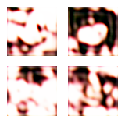

In [15]:
for step in tqdm_notebook(range(iterations)):
  random_latent_vectors = np.random.normal(size = (batch_size, latent_dim))
  generated_images = generator.predict(random_latent_vectors)
  stop = start + batch_size
  real_images = x_train[start: stop]
  combined_images = np.concatenate([generated_images, real_images])
  labels = np.concatenate([np.ones((batch_size,1)), 
                                    np.zeros((batch_size, 1))])
  labels += 0.05 * np.random.random(labels.shape)
  
  d_loss = discriminator.train_on_batch(combined_images, labels)
  
  random_latent_vectors = np.random.normal(size=(batch_size, 
                                                 latent_dim))
  misleading_targets = np.zeros((batch_size, 1))
  a_loss = gan.train_on_batch(random_latent_vectors, 
                              misleading_targets)
  start += batch_size
  
  if start > len(x_train) - batch_size:
    start = 0
 
  if step % 10 == 0:
    print('discriminator loss:', d_loss)
    print('advesarial loss:', a_loss)
    fig, axes = plt.subplots(2, 2)
    fig.set_size_inches(2,2)
    count = 0
    for i in range(2):
      for j in range(2):
        axes[i, j].imshow(resize(generated_images[count], (64,64)))
        axes[i, j].axis('off')
        count += 1
    plt.show()
    
  if step % 100 == 0:
    # Save the weight. If you want to train for a long time, make sure to save 
    # in your drive. Mount your drive here. Google on how to mount your drive
    # into colab
    gan.save_weights('model.h5')
    
    print('discriminator loss:', d_loss)
    print('advesarial loss:', a_loss)
    